<a href="https://www.kaggle.com/code/barelhatuka/house-pricing-assignment?scriptVersionId=120320274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<p style="text-align: center;">
<img src="https://img.freepik.com/premium-vector/house-is-sold-sale-home-concept-realtor-gives-keys-house-buyer_186930-556.jpg?w=1480" style='width: 600px; height: 550px;'>
</p>

<h4 style="text-align: center;"> Created By: <strong>Barel Hatuka</strong> <br>
    <a> https://www.kaggle.com/barelhatuka</a></h4>



<h1 style="text-align: center;">Table of Contents</h1>

* [1.  Introduction](#1)
* [2.  Import libraries](#2)
* [3.  Import Data](#3)
* [4.  Data Overview and Analysis](#4)
* [5.  Data Preparation](#5)
* [6.  Pipeline Preparation](#6)
* [7.  Pipeline](#7)
* [8.  Running Machine Learning](#8)
* [9.  Closer Look - Lasso Regression Model](#9)
* [10. Save and Submit](#10)
* [11. Conclusion](#11)

<a id="1"></a>
<h2 style="text-align: center;">Introduction</h2>

<div style="border-radius:10px;border:black solid;padding: 15px;font-size:110%;text-align:left">
    
<strong>Assignment:</strong> Kaggle Competition - House Prices - Advanced Regression Techniques
<br>
<strong>Summary:</strong>
- This is a machine learning contest held on the Kaggle website, the goal of the contest is to try and predict house prices from the list of features provided from the dataset. Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the predicted values and the observed sales price. 
<br>

<strong>Main Steps:</strong> <br>
- Data Overview, and Data Analysis<br>
- Data Preparation<br>
- Machine Learning Model Choice<br>
- Machine Learning Tuning<br>
- Finalize Scores<br>
- Submission

</div>

<a id="2"></a>
<h2 style="text-align: center;">Import Libraries</h2>

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from scipy import stats

<h5 style="color: gray">* pandas for reading csv files<br>
    * matplotlib for plotting the data<br>
    * seaborn for making statistical graphics (builds on top of matplotlib and integrates with pandas)<br>
    * scikit-learn is simple and efficient tool for predictive data analysis (built on numpy scipy and matplotlib)
</h5>


<a id="3"></a>
<h2 style="text-align: center;">Import Data</h2>

In [2]:
raw_train_data_dataframe = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
raw_test_data_dataframe = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

<h5 style="color: gray">saving train and test data in dataframes<br>
    we'll leave out for now test data and use train data only
</h5>


<a id="4"></a>
<h2 style="text-align: center;">Data Overview and Analysis</h2>

In [3]:
print("The shape of the dataframe is: ", raw_train_data_dataframe.shape)
raw_train_data_dataframe.info()

The shape of the dataframe is:  (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQu

<h5 style="color: gray">we can see from first look that there are 81 features (including Id)<br>
    we'll examine the data further
</h5>


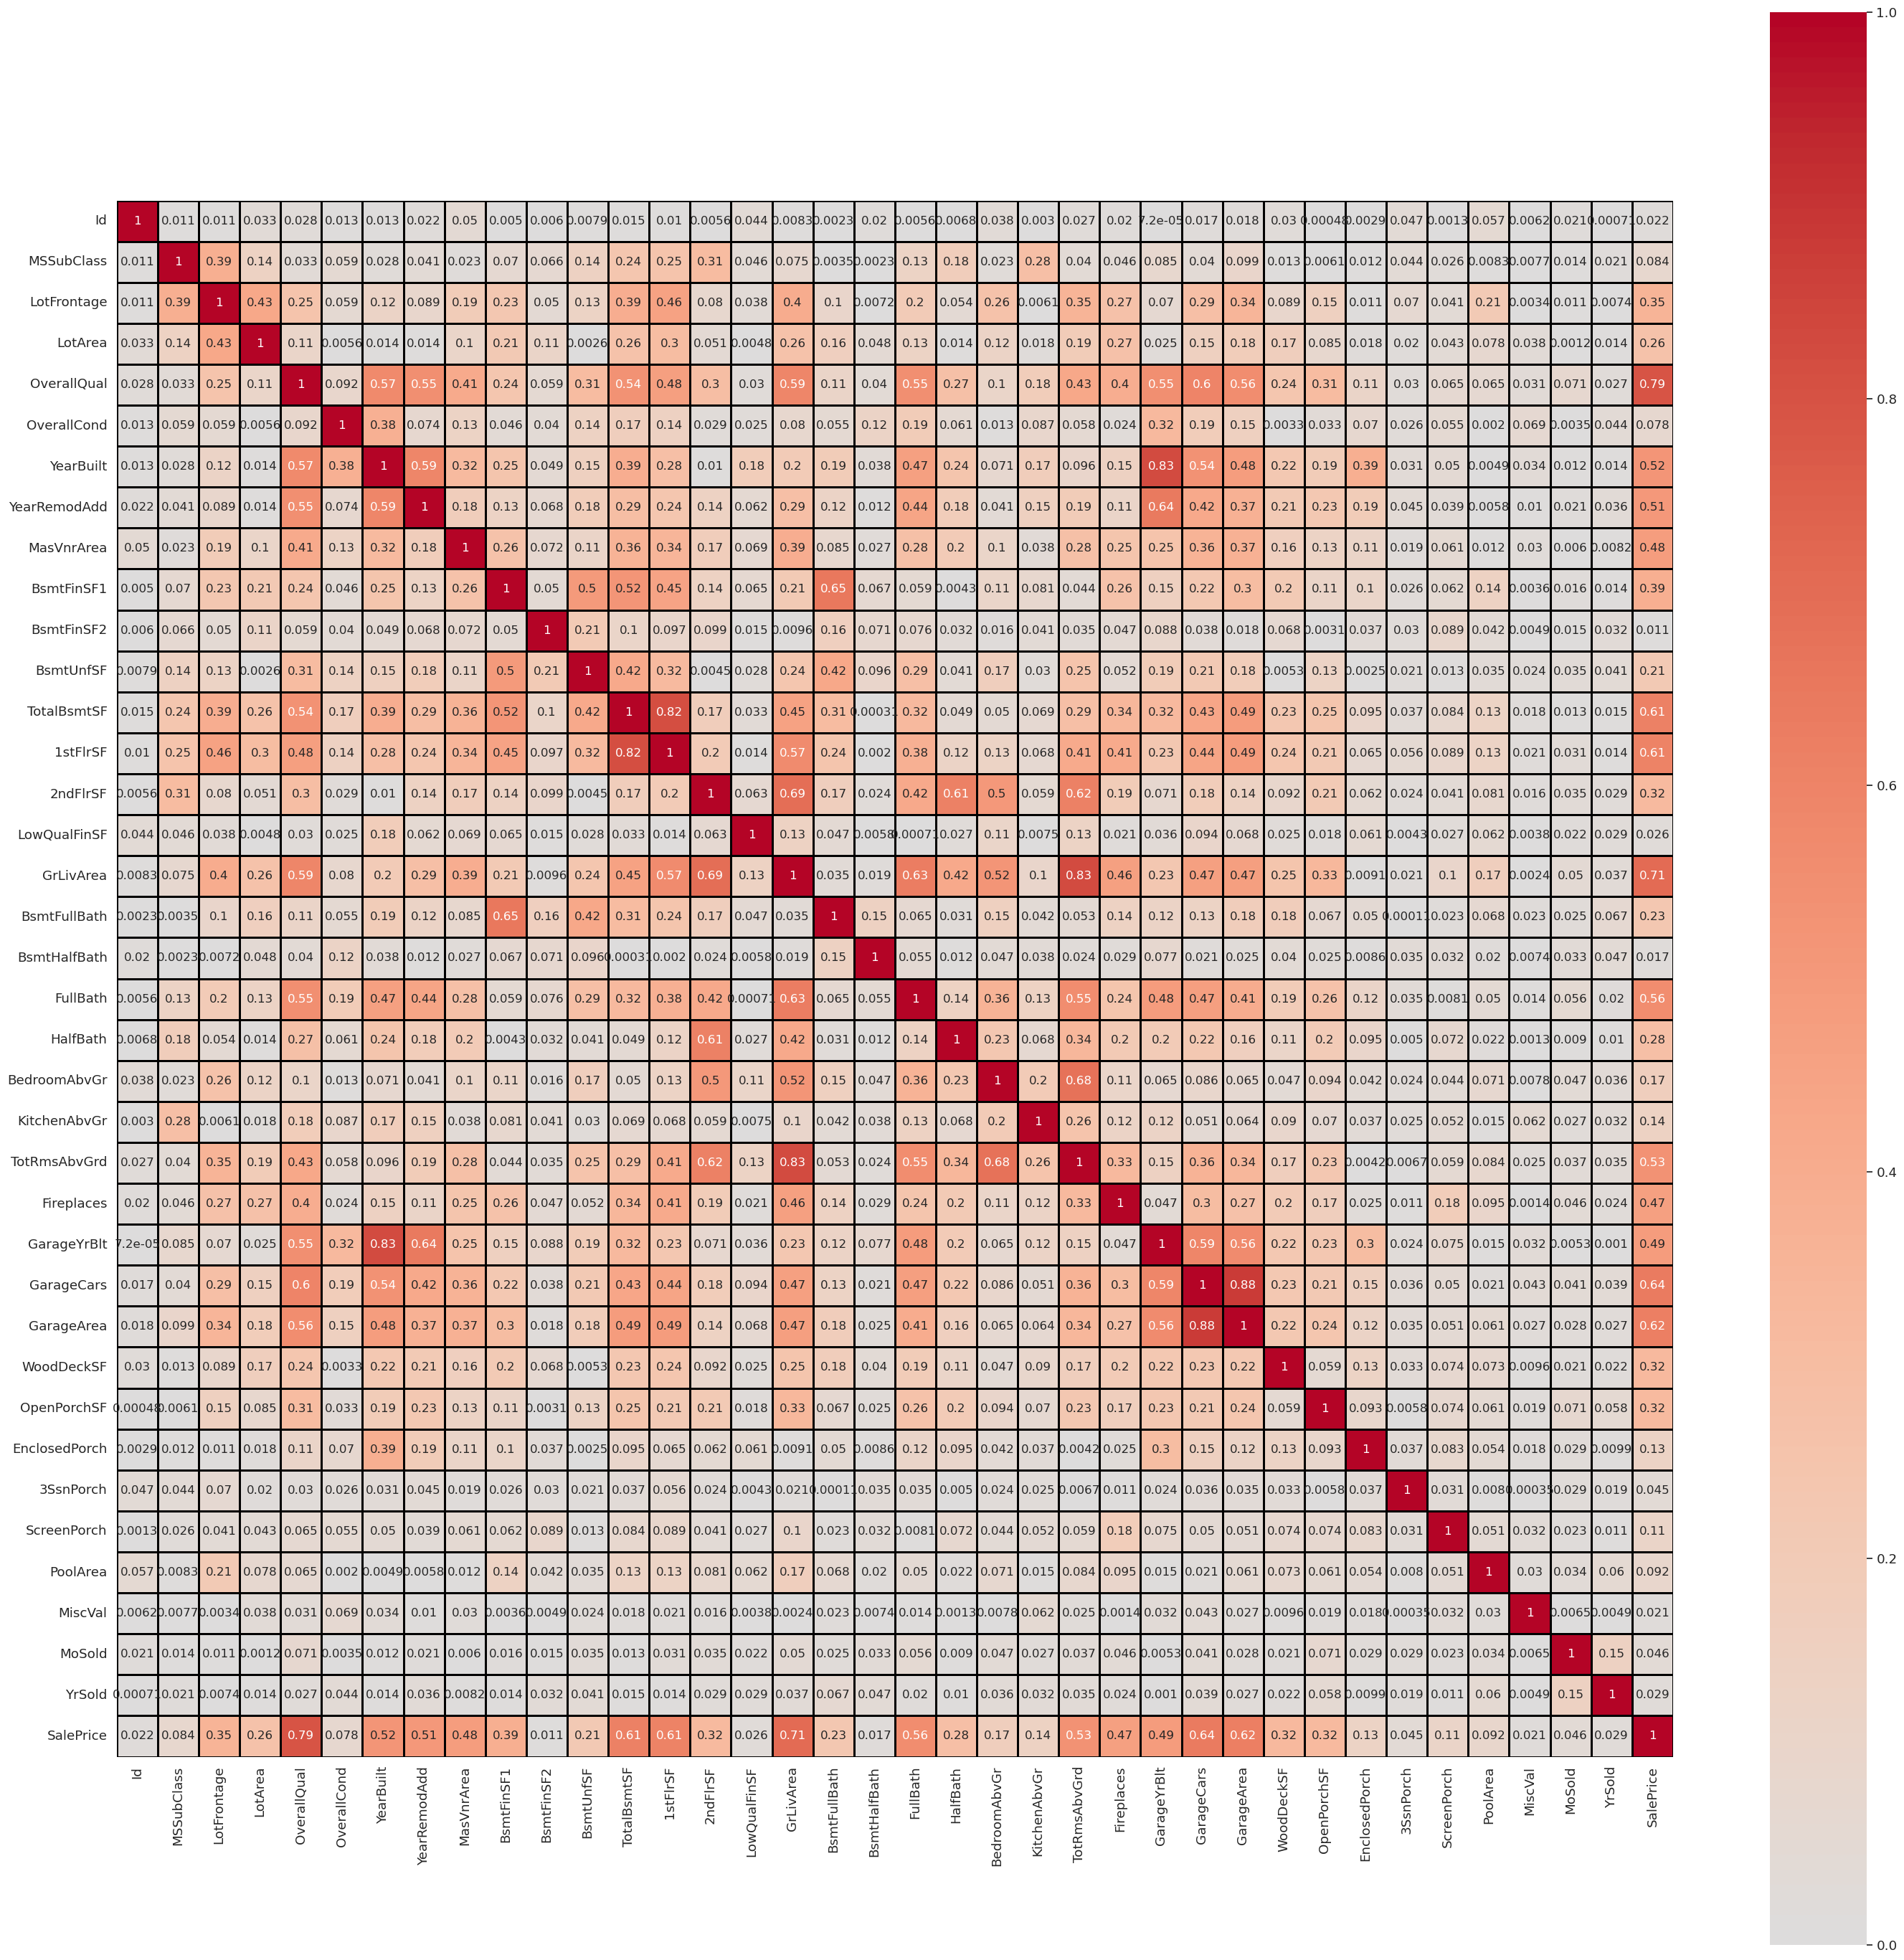

In [4]:
correlation_matrix = np.abs(raw_train_data_dataframe.corr())
sns.set(font_scale=1.2)
plt.figure(figsize=(35,35))
sns.heatmap(correlation_matrix, vmax=1, vmin=0, center=0, square=True, 
            cmap='coolwarm', annot=True, linewidths=1, linecolor='black', annot_kws={"size": 12});

<h5 style="color: gray">instead of many subplots, this heatmap is showing the correlation ratio between each two columns
</h5>


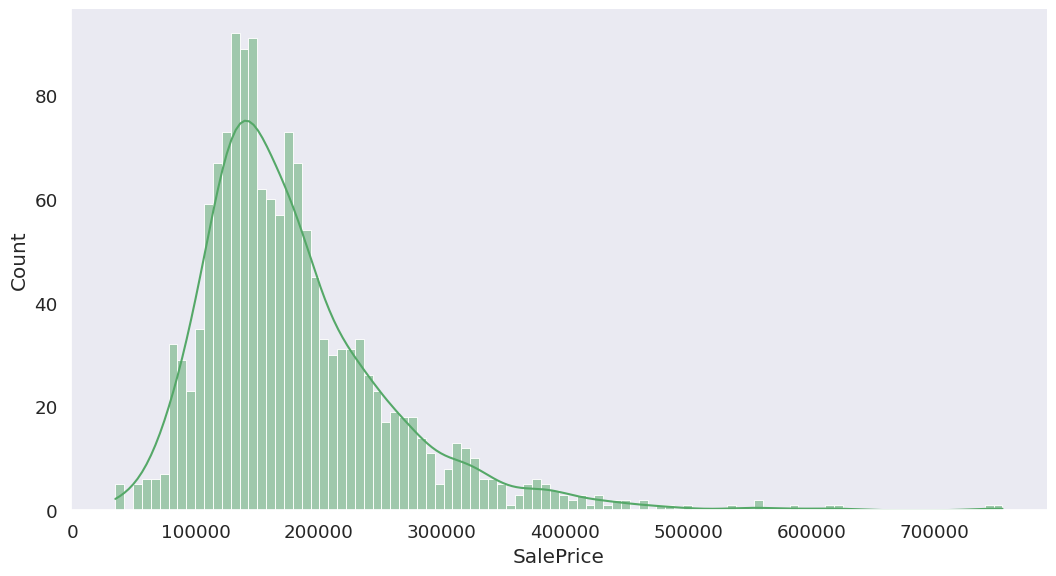

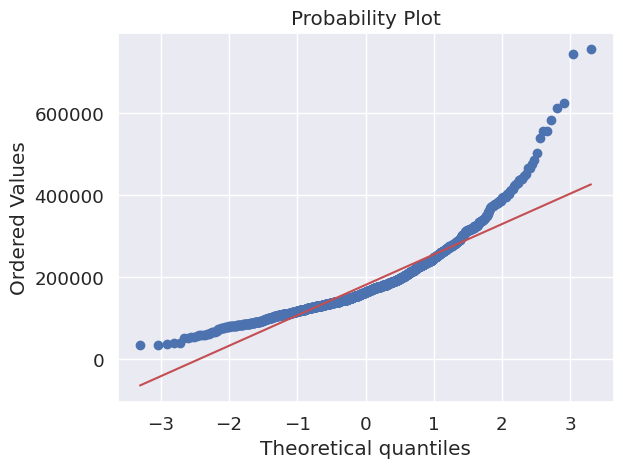

In [5]:
sns.displot(x=raw_train_data_dataframe['SalePrice'], color='g', kde=True, height=6, aspect=1.8, bins=100);
plt.grid()
figure = plt.figure()
stats.probplot(raw_train_data_dataframe['SalePrice'], plot=plt);

<h5 style="color: gray"><b>keep in mind the data is still raw with all features without any cleanup, or ordering of any sorts<br></b>
    this displot is providing access to visualize the distribution of data, in here we can see the distribution of the sale prices<br>
    kde=True is for showing the kernel density estimate (KDE) (the solid green line)<br>
    we can observe that the distribution isn't gaussian
</h5>


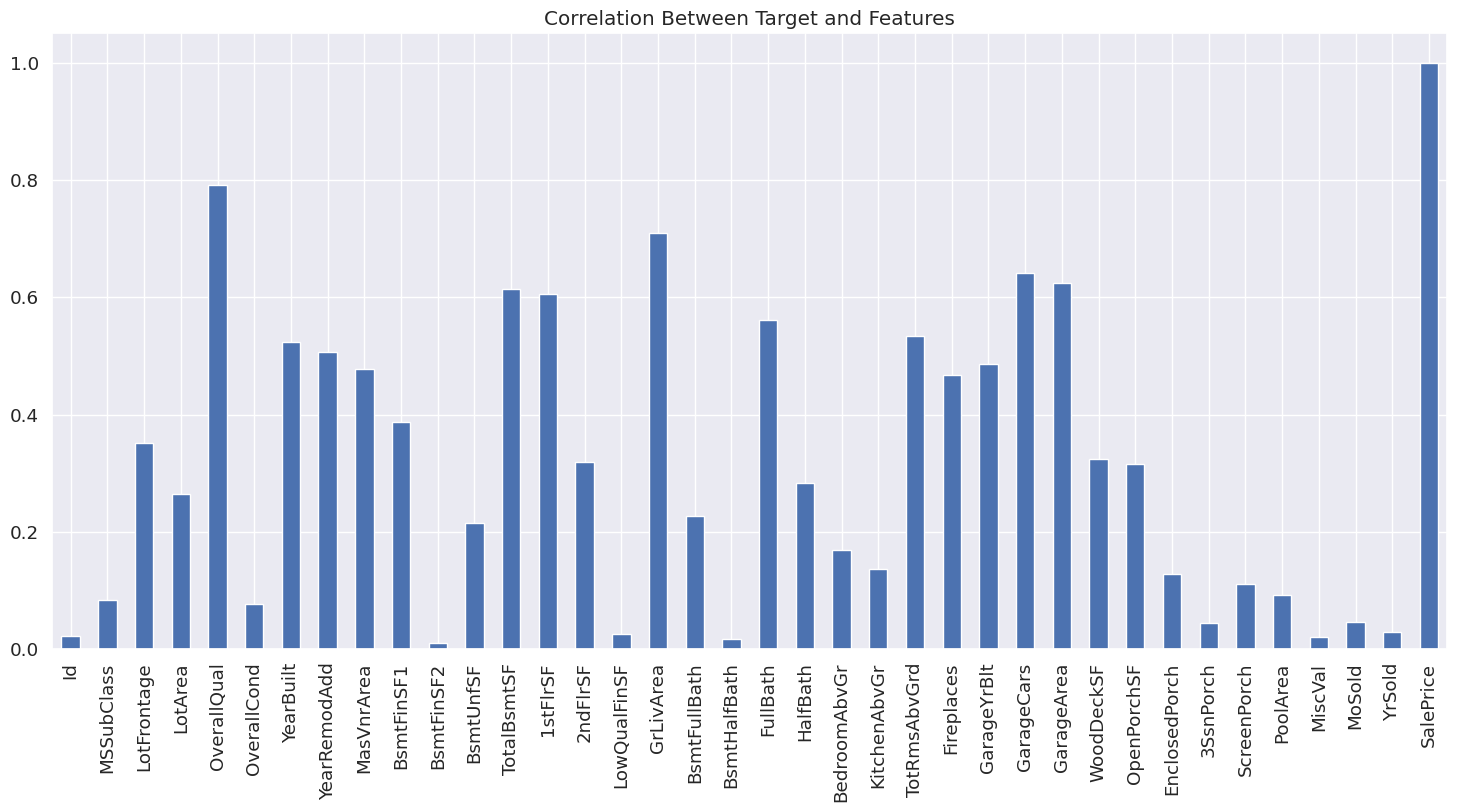

In [6]:
correlation_matrix['SalePrice'].plot(kind='bar', figsize=(18,8), title='Correlation Between Target and Features');

<h5 style="color: gray">this bar plot is showing the correlation between the column SalePrice which is the target column and each of the columns which they are the features
</h5>


In [7]:
# removing the Id column
raw_train_data_without_id_dataframe = raw_train_data_dataframe.drop(['Id'], axis=1)
target_column = raw_train_data_without_id_dataframe['SalePrice']
raw_test_data_without_id_dataframe = raw_test_data_dataframe.drop(['Id'], axis=1)

In [8]:
# getting color palette
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def preparation_before_plot(df, what_plot, number_of_rows):
    plt.style.use('seaborn')
    # creating a grid for the subplots
    number_of_columns = 4
    fig, axes = plt.subplots(number_of_rows, number_of_columns, figsize=(10,15))
    # adjustments
    plt.subplots_adjust(top=3, bottom=0, left=0, right=2.5)
    colors = get_cmap(len(df.columns))
    
    if what_plot == 0:
        box_plot_categorical_features(df, number_of_columns, axes)
    elif what_plot == 1:
        histogram_plot_density_numerical_features(df, number_of_columns, axes, colors)
    else:
        scatter_plot_with_regression_line_target_by_each_feature(df, number_of_columns,
                                                                 axes, colors)

In [9]:
def histogram_plot_density_numerical_features(df, number_of_columns, axes, colors):   
    # creating the plots
    # i counter for the plots
    for i, column in enumerate(df):
        sns.histplot(df[column], ax=axes[i//number_of_columns,i%number_of_columns], 
                     color=colors(i), kde=True)        
        axes[i//number_of_columns, i%number_of_columns].tick_params(axis='both', labelsize=20)
        axes[i//number_of_columns, i%number_of_columns].xaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].yaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].title.set_fontsize(20)

In [10]:
def box_plot_categorical_features(df, number_of_columns, axes):
    # creating the plots
    # i counter for the plots
    for i, column in enumerate(df):
        sns.boxplot(data=df, x=df[column], y=target_column, ax=axes[i//number_of_columns,i%number_of_columns])
        axes[i//number_of_columns, i%number_of_columns].tick_params(axis='both', labelsize=10)
        axes[i//number_of_columns, i%number_of_columns].xaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].yaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].title.set_fontsize(10)

In [11]:
def scatter_plot_with_regression_line_target_by_each_feature(df, number_of_columns, 
                                                             axes, colors):
    for i, column in enumerate(df):
        sns.scatterplot(data=df, x=df[column], y=target_column, color=colors(i),
                    ax=axes[i//number_of_columns,i%number_of_columns])
        axes[i//number_of_columns, i%number_of_columns].tick_params(axis='both', labelsize=10)
        axes[i//number_of_columns, i%number_of_columns].xaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].yaxis.label.set_size(20)
        axes[i//number_of_columns, i%number_of_columns].title.set_fontsize(10)

<h5 style="color: gray">above are the methods for visualizing all the categorical and numerical plots
</h5>

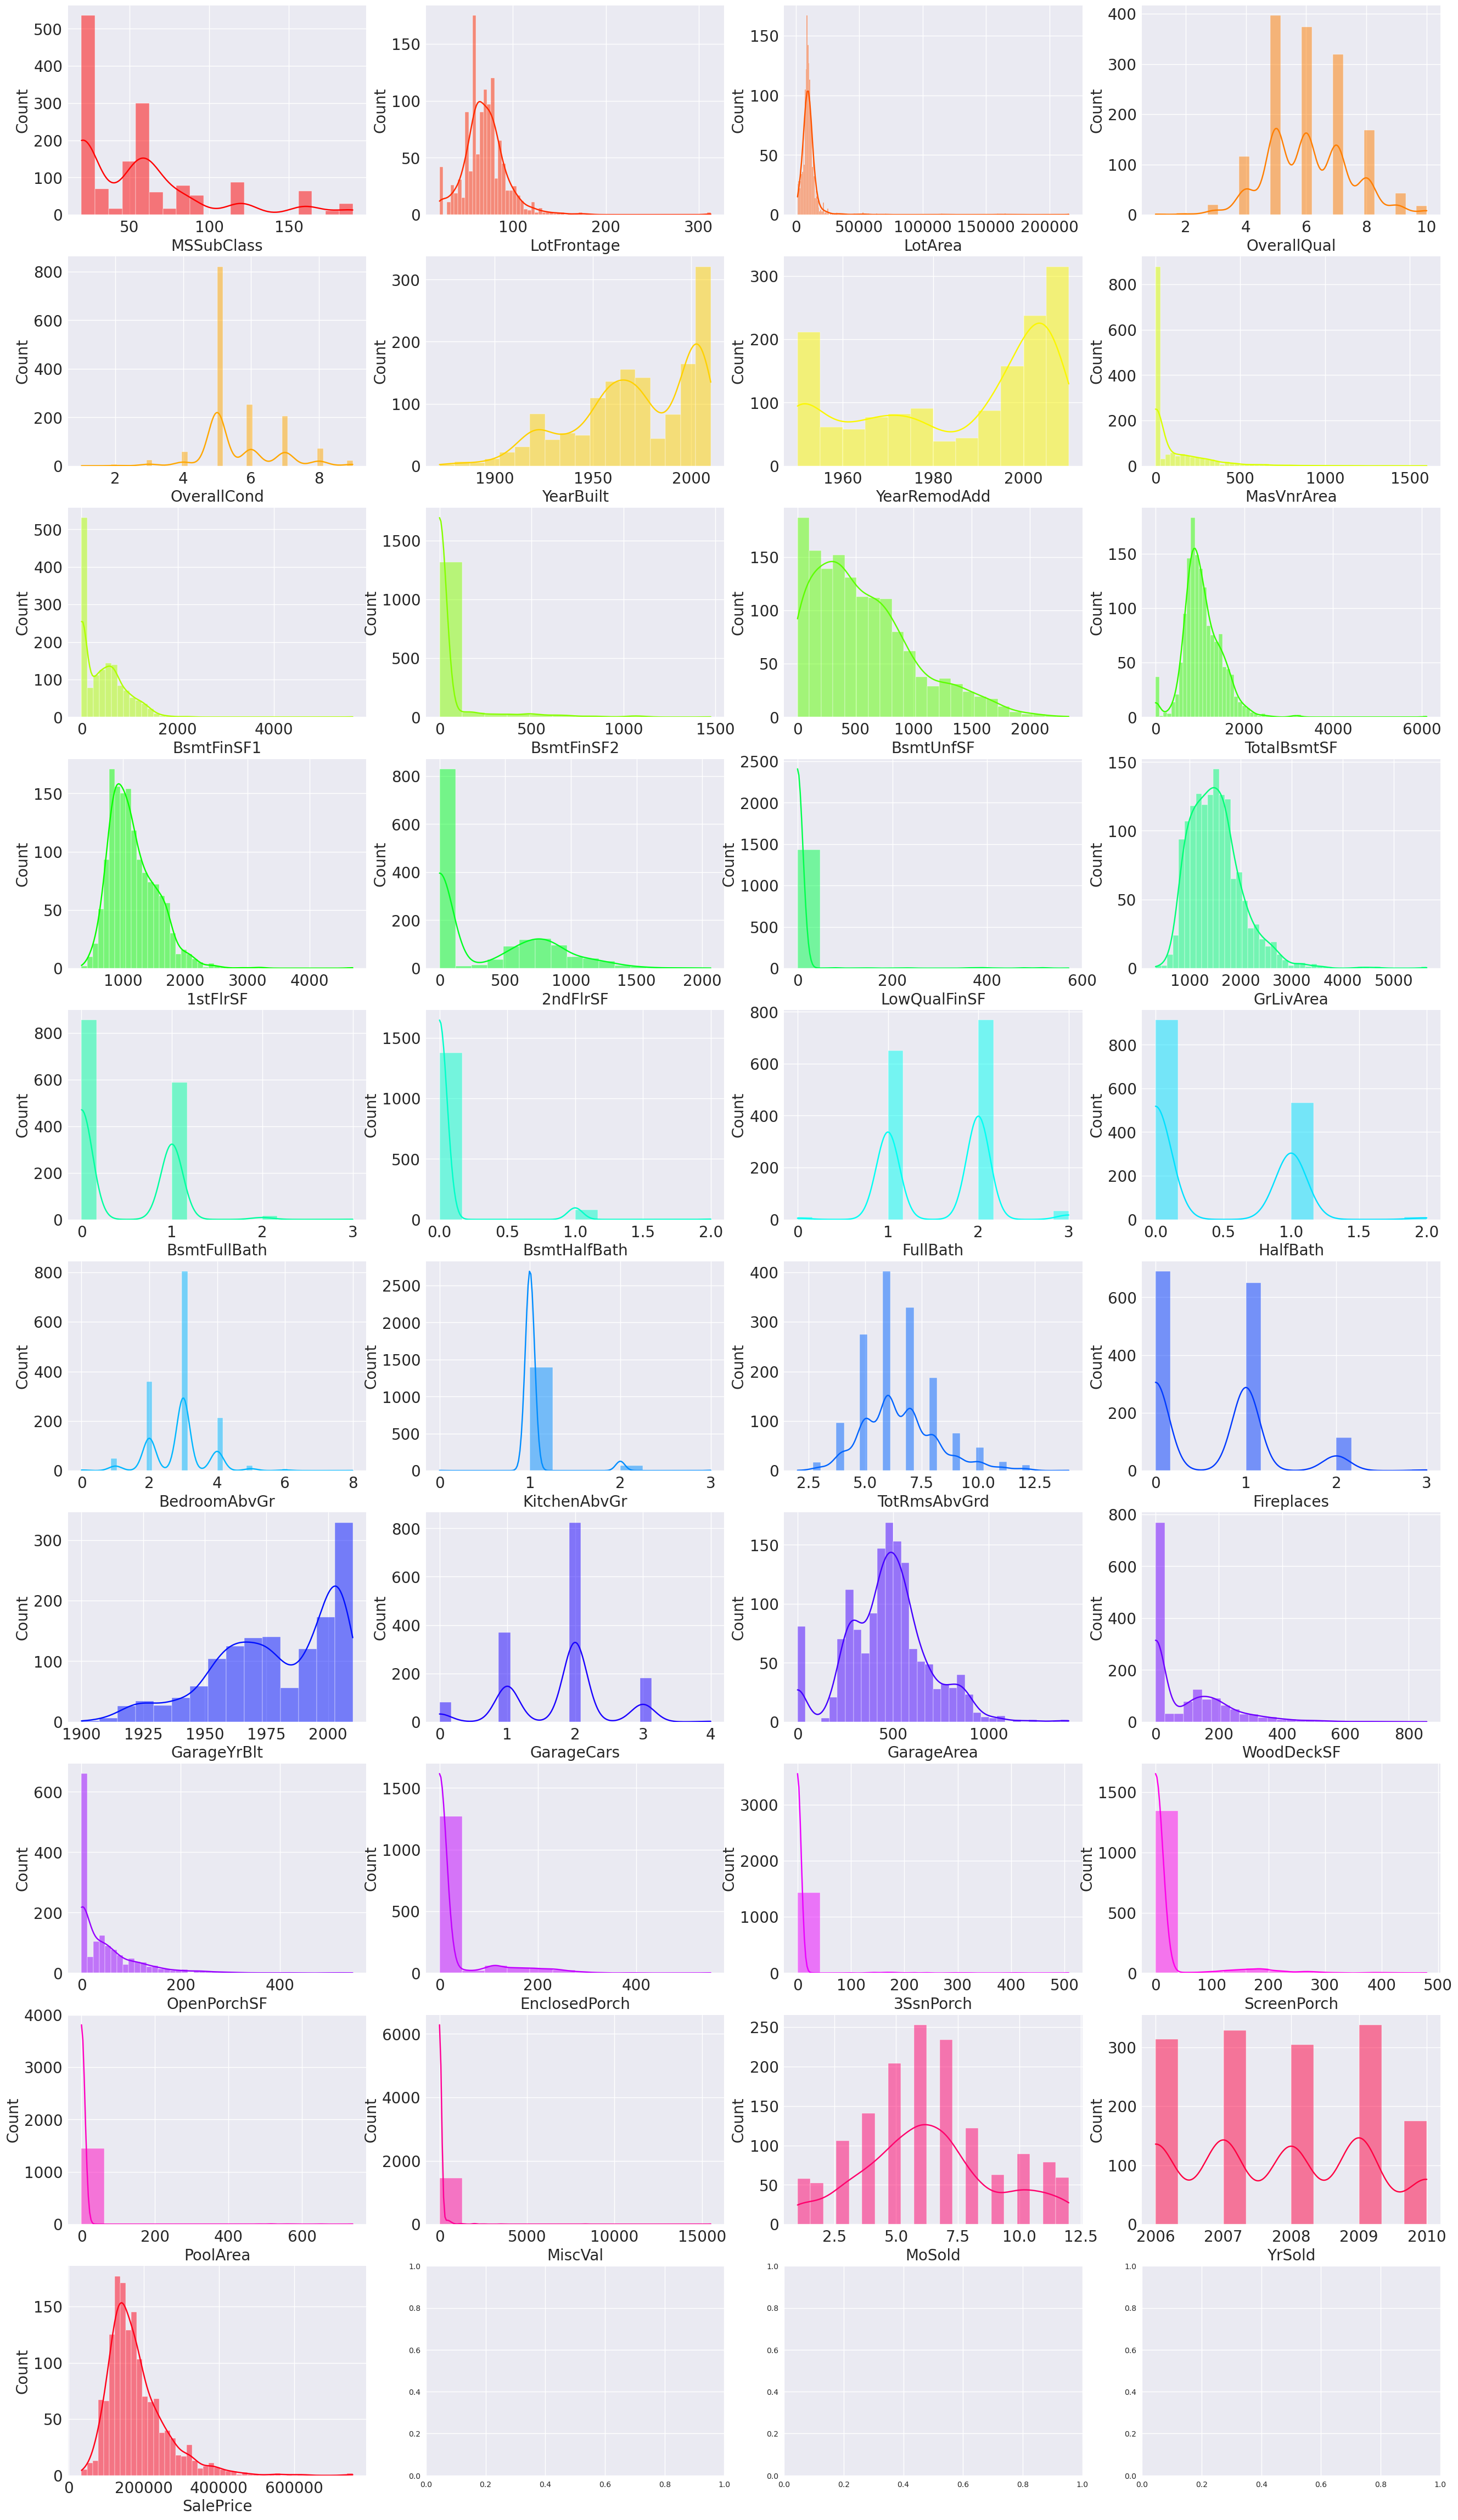

In [12]:
preparation_before_plot(raw_train_data_without_id_dataframe.select_dtypes(exclude=['object']), 1, 10)

<h5 style="color: gray">as we can see, we're watching all the numerical features that the data has to offer
</h5>


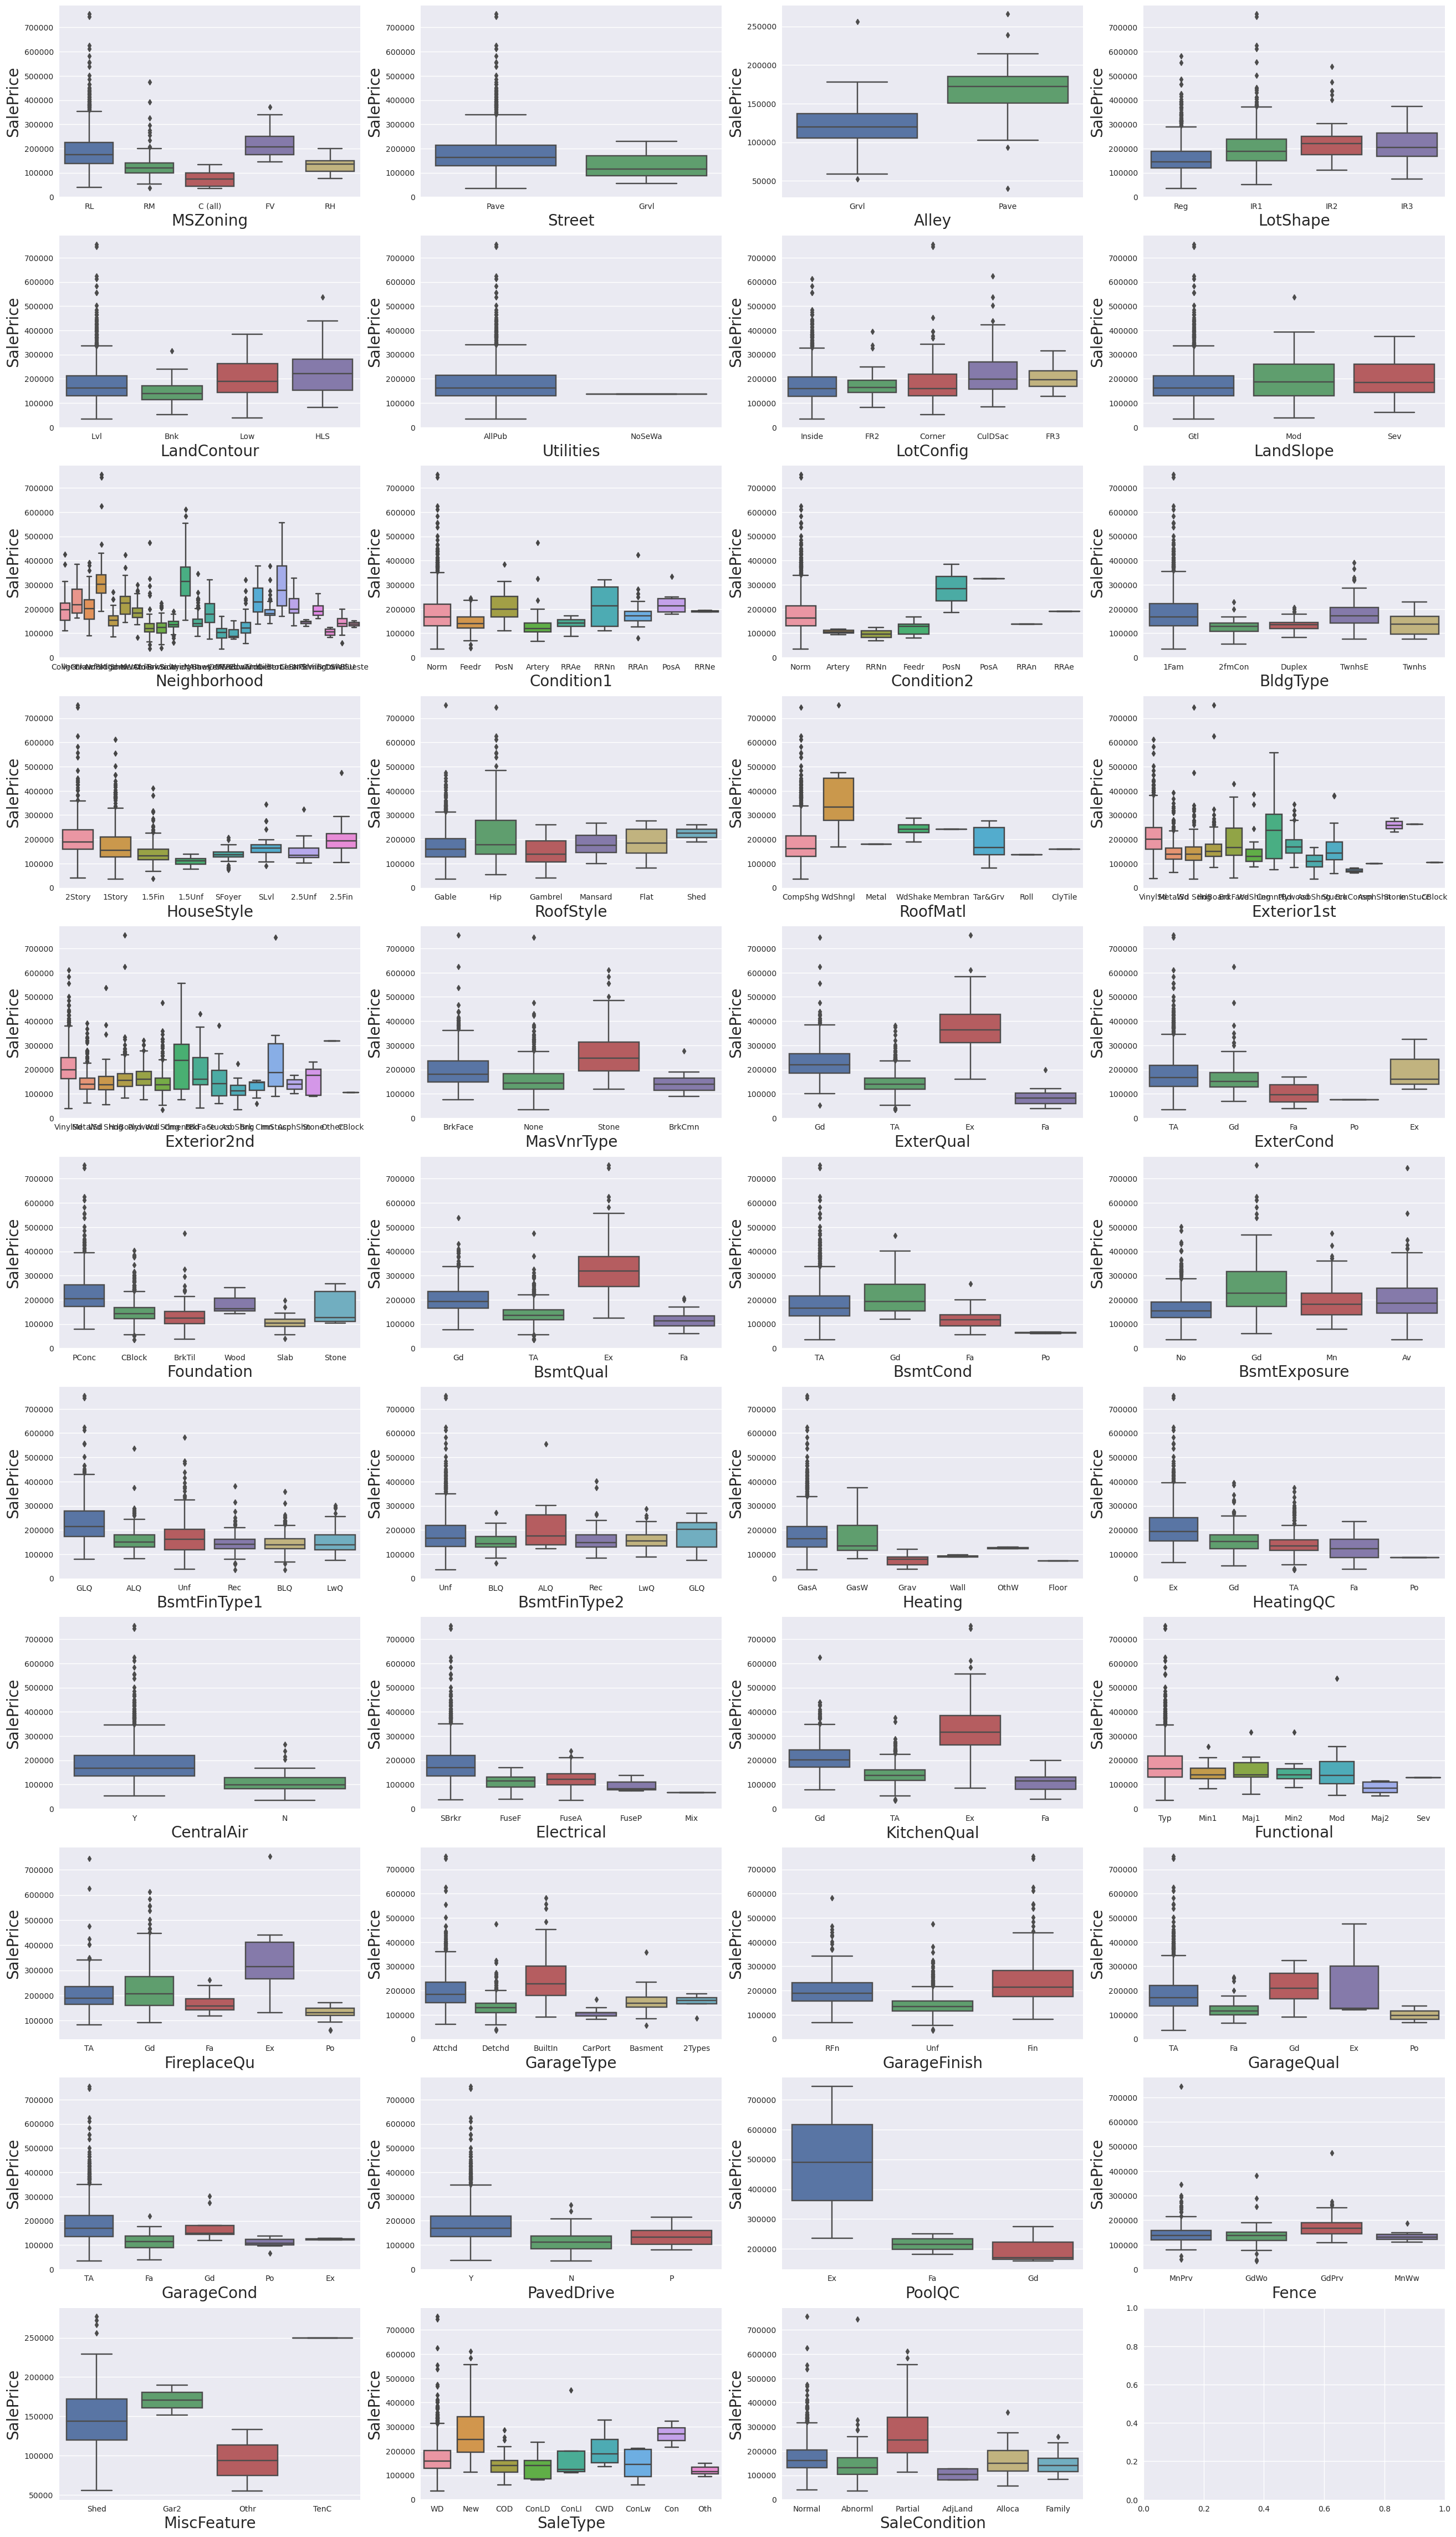

In [13]:
preparation_before_plot(raw_train_data_without_id_dataframe.select_dtypes('object'), 0, 11)

<h5 style="color: gray">here we can see all the categorical features in boxplots
</h5>

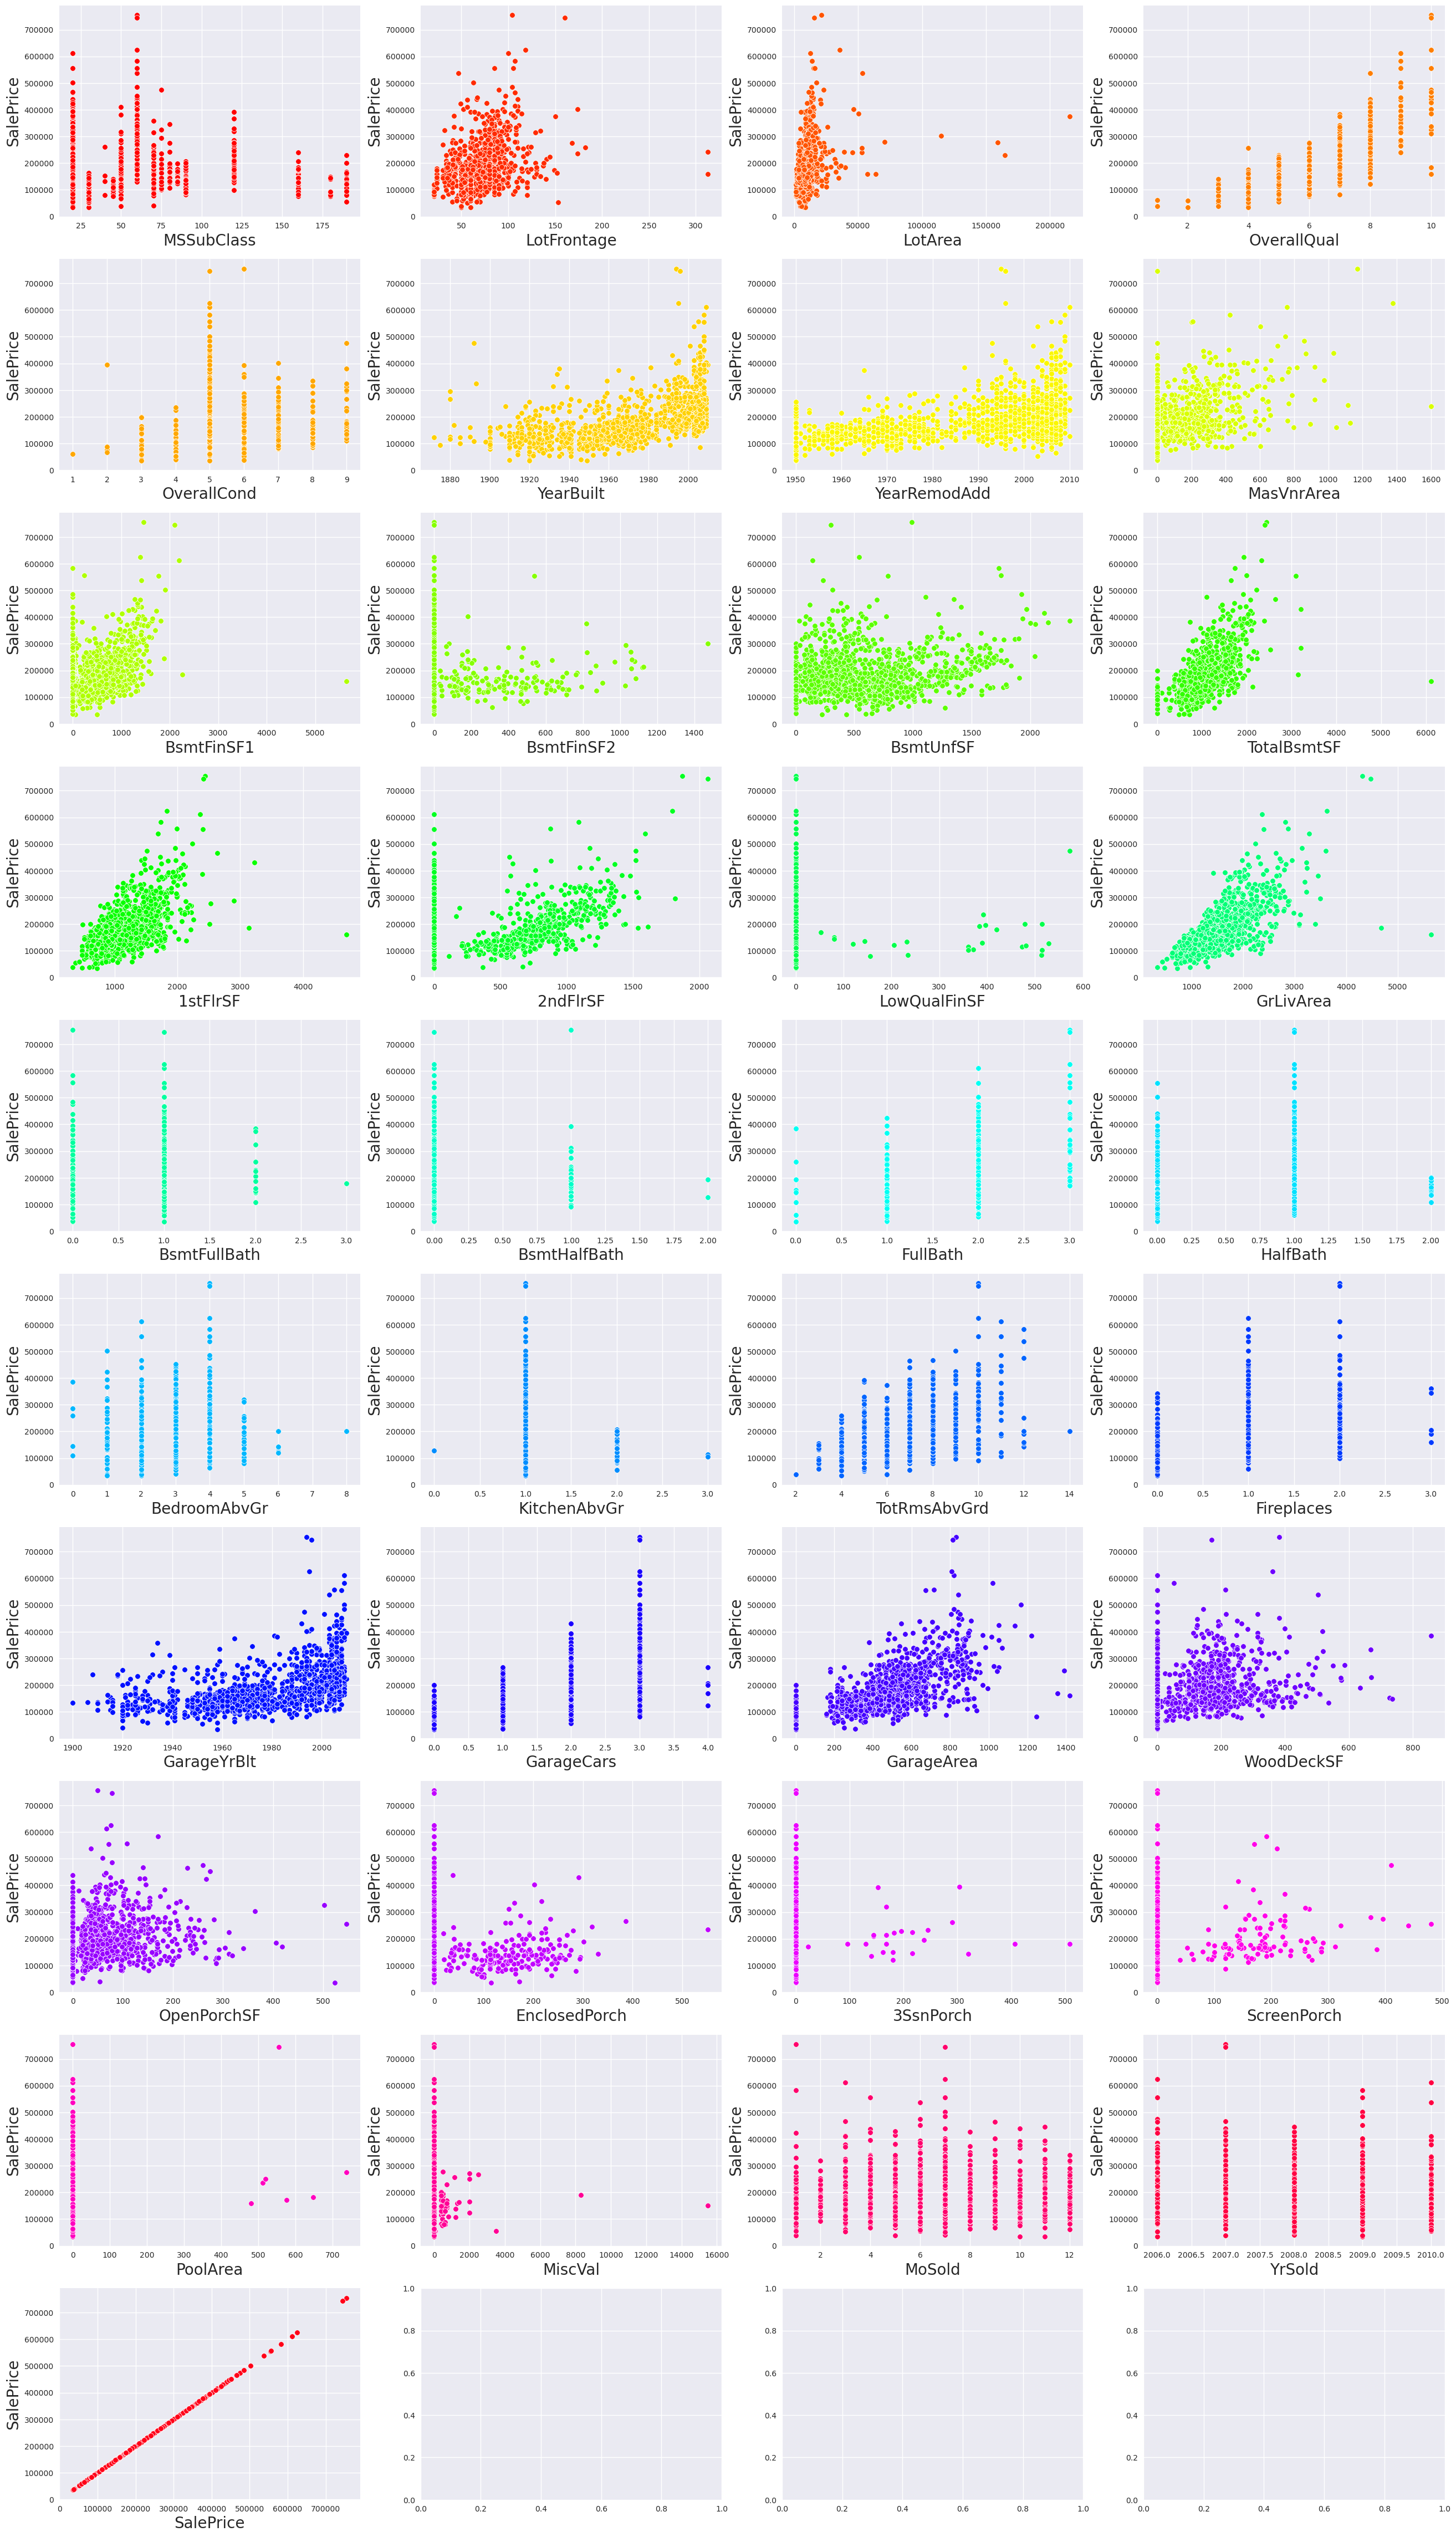

In [14]:
preparation_before_plot(raw_train_data_without_id_dataframe.select_dtypes(exclude=['object']), 2, 10)

<h5 style="color: gray">here we can see all the numerical features with scatter plots, we can see some are correlated and a very good candidates for predicting our sale prices
</h5>

<a id="5"></a>
<h2 style="text-align: center;">Data Preparation</h2>

<h5 style="color: gray">now we'll take a closer look on all the features with missing values and what does it mean
</h5>

In [15]:
(raw_train_data_without_id_dataframe.isna().sum()).loc[
    (raw_train_data_without_id_dataframe.isna().sum() != 0)].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

<h5 style="color: gray">this is the <b><u>training data</u></b> list of all features [columns] with null values and their amount, categorical and numerical<br><br>
    &emsp; LotFrontage: Linear feet of street connected to property <u>[numerical]</u> (NA is Missing Values)<br>
    &emsp; Alley: Type of alley access to property (NA is No Alley Access)<br>
    &emsp; MasVnrType: Masonry veneer type (NA is Missing Values)<br>
    &emsp; MasVnrArea: Masonry veneer area in square feet <u>[numerical]</u> (NA is Missing Values)<br>
    &emsp; BsmtQual: Evaluates the height of the basement (NA is No Basement)<br>
    &emsp; BsmtCond: Evaluates the general condition of the basement (NA is No Basement)<br>
    &emsp; BsmtExposure: Refers to walkout or garden level walls (NA is No Basement)<br>
    &emsp; BsmtFinType1: Rating of basement finished area (NA is No Basement)<br>
    &emsp; BsmtFinType2: Rating of basement finished area (if multiple types) (NA is No Basement)<br>
    &emsp; Electrical: Electrical system (NA is Missing Values)<br>
    &emsp; FireplaceQu: Fireplace quality (NA is No Fireplace)<br>
    &emsp; GarageType: Garage location (NA is No Garage)<br>
    &emsp; GarageYrBlt: Year garage was built <u>[numerical]</u> (NA is No Garage)<br>
    &emsp; GarageFinish: Interior finish of the garage (NA is No Garage)<br>
    &emsp; GarageQual: Garage quality (NA is No Garage)<br>
    &emsp; GarageCond: Garage condition (NA is No Garage)<br>
    &emsp; PoolQC: Pool quality (NA is No Pool)<br>
    &emsp; Fence: Fence quality (NA is No Fence)<br>
    &emsp; MiscFeature: Miscellaneous feature not covered in other categories (NA is None)<br>
    
we can see that only 3 are numerical and all else are categorical<br>
we can see that we have 4 main features that have more than 50% missing values, we'll take a closer look
</h5>

In [16]:
(raw_test_data_without_id_dataframe.isna().sum()).loc[
    (raw_test_data_without_id_dataframe.isna().sum() != 0)].sort_values(ascending=False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

<h5 style="color: gray">those are the null values for the test dataset, we'll need to manage that before we're trying to predict on that dataset.<br>
    to avoid data leakage we'll procceed with handling them side by side but not together
</h5>

In [17]:
all_columns_list = raw_train_data_without_id_dataframe.columns.tolist()
all_categorical_columns_list = raw_train_data_without_id_dataframe.select_dtypes('object').columns
all_numerical_columns_list = raw_train_data_without_id_dataframe.select_dtypes(np.number).columns

<h5 style="color: gray">    seperating the categorical and numerical features<br>
    removing the last element from the numerical columns list because it's our target<br>
    since train and test datasets has the same columns, it's enough to get the lists from one of them
</h5>

In [18]:
for column in all_categorical_columns_list:
    print(f'{column}: {raw_train_data_without_id_dataframe[column].unique()}')

MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street: ['Pave' 'Grvl']
Alley: [nan 'Grvl' 'Pave']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st: ['Vi

<h5 style="color: gray">we can see from our last output, all the unique values of the categorical features<br>
    at a closer look we can see that some are ordinal (ex. bad, fine, good, excellent) and the others are random (ex. pave, gravle etc.), with that, we need to procceed with cautious
</h5>

<a id="6"></a>
<h2 style="text-align: center;">Pipeline Preparation</h2>

In [19]:
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
none_imputer = SimpleImputer(fill_value='None', strategy='constant')
zero_imputer = SimpleImputer(fill_value=0, strategy='constant')
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

<h5 style="color: gray">SimpleImputer is for completing missing values with simple strategies<br>
    the reason the parameter missing_values is missing is because its default is np.nan<br><br>
    OneHotEncoder is for encode categorical features as a one-hot numeric array, meaning encoding the features which their order doesn't matter much
</h5>

In [20]:
oridnal_columns_ordered_dict = {
    "MSSubClass": [ 20, 30,40,45,50,60,70,75,80,85, 90,120,150,160,180,190], 
    "LotShape": ['Reg','IR1' ,'IR2','IR3'], 
    "ExterQual": ['Po','Fa','TA','Gd','Ex'], 
    "ExterCond": ['Po','Fa','TA','Gd','Ex'],
    "HeatingQC": ['Po','Fa','TA','Gd','Ex'], 
    "Functional": ['Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], 
    "KitchenQual": ['Fa','TA','Gd','Ex'], 
    "FireplaceQu": ['None','Po','Fa','TA','Gd','Ex'], 
    "GarageFinish": ['None','Unf','RFn','Fin'], 
    "GarageQual": ['None','Po','Fa','TA','Gd','Ex'], 
    "GarageCond": ['None','Po','Fa','TA','Gd','Ex'], 
    "PoolQC": ['None','Fa','Gd','Ex'], 
    "Fence": ['None','MnWw','GdWo','MnPrv','GdPrv'],
    "BsmtQual": ['None','Fa','TA','Gd','Ex'], 
    "BsmtCond": ['None','Po','Fa','TA','Gd','Ex'], 
    "BsmtExposure": ['None','No','Mn','Av','Gd'], 
    "BsmtFinType1": ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ], 
    "BsmtFinType2": ['None','Unf','LwQ', 'Rec','BLQ','ALQ' , 'GLQ' ]
}

<h5 style="color: gray">above we can see a dictionary of our unique ordinal columns<br>
    because order is matter for OrdinalEncoder we need to keep the data in order
</h5>

In [21]:
# list of train data columns with na values
train_data_columns_with_na_values_list = raw_train_data_without_id_dataframe.columns[
    raw_train_data_without_id_dataframe.isna().any()].tolist()

# list of test data columns with na values
test_data_columns_with_na_values_list = raw_test_data_without_id_dataframe.columns[
    raw_test_data_without_id_dataframe.isna().any()].tolist()

train_and_test_columns_with_na_values_list = list(set(
train_data_columns_with_na_values_list + test_data_columns_with_na_values_list))

In [22]:
columns_for_median_list = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

columns_for_ordinal_mode_list = [column for column in oridnal_columns_ordered_dict.keys() 
                            if 'None' not in oridnal_columns_ordered_dict[column]]

columns_for_one_hot_mode_list = [column for column in all_categorical_columns_list
                           if column not in oridnal_columns_ordered_dict.keys()
                           and column not in train_and_test_columns_with_na_values_list]
 # append electrical and masvnrtype
columns_for_one_hot_mode_list.append('Electrical')
columns_for_one_hot_mode_list.append('MasVnrType')

columns_for_ordinal_none_list = [column for column in oridnal_columns_ordered_dict.keys() 
                            if 'None' in oridnal_columns_ordered_dict[column]]

columns_for_one_hot_none_list = [column for column in all_categorical_columns_list
                           if column not in oridnal_columns_ordered_dict.keys()
                           and column in train_and_test_columns_with_na_values_list
                           and column not in columns_for_one_hot_mode_list]

columns_for_zero_list = [column for column in all_numerical_columns_list
                   if column not in columns_for_median_list
                   and column not in oridnal_columns_ordered_dict.keys()
                   and column in train_and_test_columns_with_na_values_list]

remainder_columns_list = [column for column in all_columns_list
                    if column not in columns_for_median_list
                    and column not in columns_for_ordinal_mode_list
                    and column not in columns_for_one_hot_mode_list
                    and column not in columns_for_ordinal_none_list
                    and column not in columns_for_one_hot_none_list
                    and column not in columns_for_zero_list]

<h5 style="color: gray">those columns lists are for the encoders, except the remainder columns, they will passthrough the column transformer to the standard scaler
</h5>

In [23]:
mode_ordinal_encoder = OrdinalEncoder(
    categories=[oridnal_columns_ordered_dict[i] for i in columns_for_ordinal_mode_list])
none_ordinal_encoder = OrdinalEncoder(
    categories=[oridnal_columns_ordered_dict[i] for i in columns_for_ordinal_none_list])

<h5 style="color: gray">above are the ordianl encoders, those are for categorical features just as one-hot encoder is, only that ordinal encoder is for when the order of the values are matter (scores in words and such)
</h5>

In [24]:
# this is for purely categorical features (labels that need to be encoded)
one_hot_encoder_mode_transformer = Pipeline(steps=[
    ('mode', mode_imputer), 
    ('encoder', one_hot_encoder) 
])

# this is for categorical features but where the order is matter (scores and such)
ordinal_encoder_mode_transformer = Pipeline(steps=[
    ('mode', mode_imputer),
    ('encoder', mode_ordinal_encoder)
])

# this is for categorical features but need to get that NaN filled with None first
one_hot_encoder_none_transformer = Pipeline(steps=[
    ('none', none_imputer),
    ('encoder', one_hot_encoder)
])

# this is for categorical feartures where the order is matter with None
ordinal_encoder_none_transformer = Pipeline(steps=[
    ('none', none_imputer),
    ('encoder', none_ordinal_encoder)
])

In [25]:
columns_transformer = ColumnTransformer(transformers=[
    ('zero', zero_imputer, columns_for_zero_list),
    ('median', median_imputer, columns_for_median_list),
    ('ordianl-mode', ordinal_encoder_mode_transformer, columns_for_ordinal_mode_list),
    ('one-hot-mode', one_hot_encoder_mode_transformer, columns_for_one_hot_mode_list),
    ('ordinal-none', ordinal_encoder_none_transformer, columns_for_ordinal_none_list),
    ('one-hot-none', one_hot_encoder_none_transformer, columns_for_one_hot_none_list)
], remainder='passthrough')

<h5 style="color: gray">the flag 'passthrough' is for all the remainder columns which didn't send to the ColumnTransformer, the default flag is 'drop', which means every column that didn't get into the transformer will be ignored and won't come through
</h5>

In [26]:
preprocess = Pipeline([
    ('columns-transformer', columns_transformer),
    ('standard-scaler', StandardScaler())
])

# set_config is for presenting the pipeline as a diagram and not as a text
set_config(display='diagram')

In [27]:
models_list = {
    'linear-regression': LinearRegression(),
    'gradient-boosting': GradientBoostingRegressor(random_state=10),
    'ridge-cv': RidgeCV(cv=42),
    'lasso-cv': LassoCV(cv=42, tol=0.001, random_state=42)
}

<h5 style="color: gray">these are the models we'll train and test for best
</h5>

<a id="7"></a>
<h2 style="text-align: center;">Pipeline</h2>

In [28]:
preprocess

Pipeline(steps=[('columns-transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'GarageCars',
                                                   'GarageArea']),
                                                 ('median',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage', 'MasVnrArea',
                                                   'GarageYrBlt']),
                                                 (...
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2']),
                                                 ('one-hot-none',
                                                  Pipeline(steps=[('none',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MSZoning', 'Alley',
                                                   'Utilities', 'Exterior1st',
                                                   'Exterior2nd', 'GarageType',
                                                   'MiscFeature',
                                                   'SaleType'])])),
                ('standard-scaler', StandardScaler())])

<a id="8"></a>
<h2 style="text-align: center;">Running Machine Learning</h2>

In [29]:
target_column = raw_train_data_without_id_dataframe['SalePrice']
modified_train_data_without_target_and_id_dataframe = raw_train_data_without_id_dataframe.drop(
['SalePrice'], axis=1)

<h5 style="color: gray">removing the 'SalePrice' column and saving it seperatly
</h5>

In [30]:
def evaluate_rmse(true_target, predicted_target):
    return mean_squared_error(true_target, predicted_target, squared=False)

<h5 style="color: gray">this method is calculating the Root Mean Squared Error for each model fitted
</h5>

In [31]:
raw_train, raw_test, target_train, target_test = train_test_split(
    modified_train_data_without_target_and_id_dataframe, target_column, test_size=0.05, random_state=10)

<h5 style="color: gray">the train_test_split method is "spliting arrays or matrices into random train and test subsets." [from documentation], basicly it divides the dataset provided into 4 pieces, one big dataset and its target, and the rest for test dataset and its target
</h5>

In [32]:
preprocessed_train = preprocess.fit(raw_train)
columns_after_one_hot_mode_list = list(preprocessed_train['columns-transformer'].transformers_[3][1]\
                                     ['encoder'].get_feature_names_out())
columns_after_one_hot_none_list = list(preprocessed_train['columns-transformer'].transformers_[5][1]\
                                     ['encoder'].get_feature_names_out())
preprocessed_train = preprocess.transform(raw_train)

<h5 style="color: gray">those are the lists of new columns after applying the OneHotEncoder, we are saving them for later
</h5>

In [33]:
preprocessed_train_test = preprocess.transform(raw_test)
preprocessed_train.shape

(1387, 230)

<h5 style="color: gray">originally we had 79 features (excluding Id and SalePrice), we can see after applying the pipeline and OneHotEncoder, we got extra 151 features
</h5>

In [34]:
score = dict()
for key in models_list.keys():
    models_list[key] = models_list[key].fit(preprocessed_train, target_train)
    predicted_target_test = models_list[key].predict(preprocessed_train_test)
    score[key] = [evaluate_rmse(target_test, predicted_target_test)]
scores_dataframe = pd.DataFrame(score).T.round(5)
scores_dataframe.columns=['RMSE Score']
scores_dataframe

RMSE Score
linear-regression  23265.46581
gradient-boosting  25995.11075
ridge-cv           23142.48889
lasso-cv           23978.00984

<h5 style="color: gray">those are the scores of the models listed on the partialy train data provided by the train_test_split method used above<br>
    we'll take a closer look on the model Lasso, even though it didn't perform the best
</h5>

<a id="9"></a>
<h2 style="text-align: center;">Closer Look - Lasso Regression Model</h2>

<h5 style="color: gray">Introduction to Lasso:
    <p>"In statistics and machine learning, lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model." <u>[from Wikipedia]</u><br>
    the advantage of Lasso above others is that this model is performing feature selection during the fitting, the features which left out will get coefficient of 0 and that way the model will use less features, not like Ridge, which also favor some features above others, but it won't zero out their coefficient and will use all the features provided</p>
</h5>

In [35]:
len([value for value in np.abs(models_list['lasso-cv'].coef_) if value > 0])

51

<h5 style="color: gray">we can see that the amount of coefficients the model has chosen to work with is much less then the provided (230)
</h5>

In [36]:
list_of_all_features = columns_for_median_list + columns_for_ordinal_mode_list + \
columns_after_one_hot_mode_list + columns_for_ordinal_none_list + \
columns_after_one_hot_none_list + columns_for_zero_list + remainder_columns_list

<h5 style="color: gray">list of all features, especially after using OneHotEncoder
</h5>

In [37]:
list_for_dataframe = list(zip(list_of_all_features, np.abs(models_list['lasso-cv'].coef_)))
selected_features = pd.DataFrame(list_for_dataframe, columns=['Feature', 'Abs_Coef'])
selected_features = selected_features.loc[selected_features['Abs_Coef'] > 0].reset_index()
selected_features.drop('index', axis=1, inplace=True)
selected_features.head(10)

Feature     Abs_Coef
0  LotFrontage  8704.960046
1   MSSubClass  2351.165057
2    ExterCond  2228.847963
3    HeatingQC  3053.178978
4   Functional   994.742344
5  KitchenQual  3705.687900
6      x0_Grvl   468.912298
7      x0_Pave  4631.719615
8       x1_HLS  5676.940792
9       x1_Lvl   823.993204

<h5 style="color: gray">we can assure that the order of the coefficients and the order of the features is the same because that is the order it fed to the pipeline
</h5>

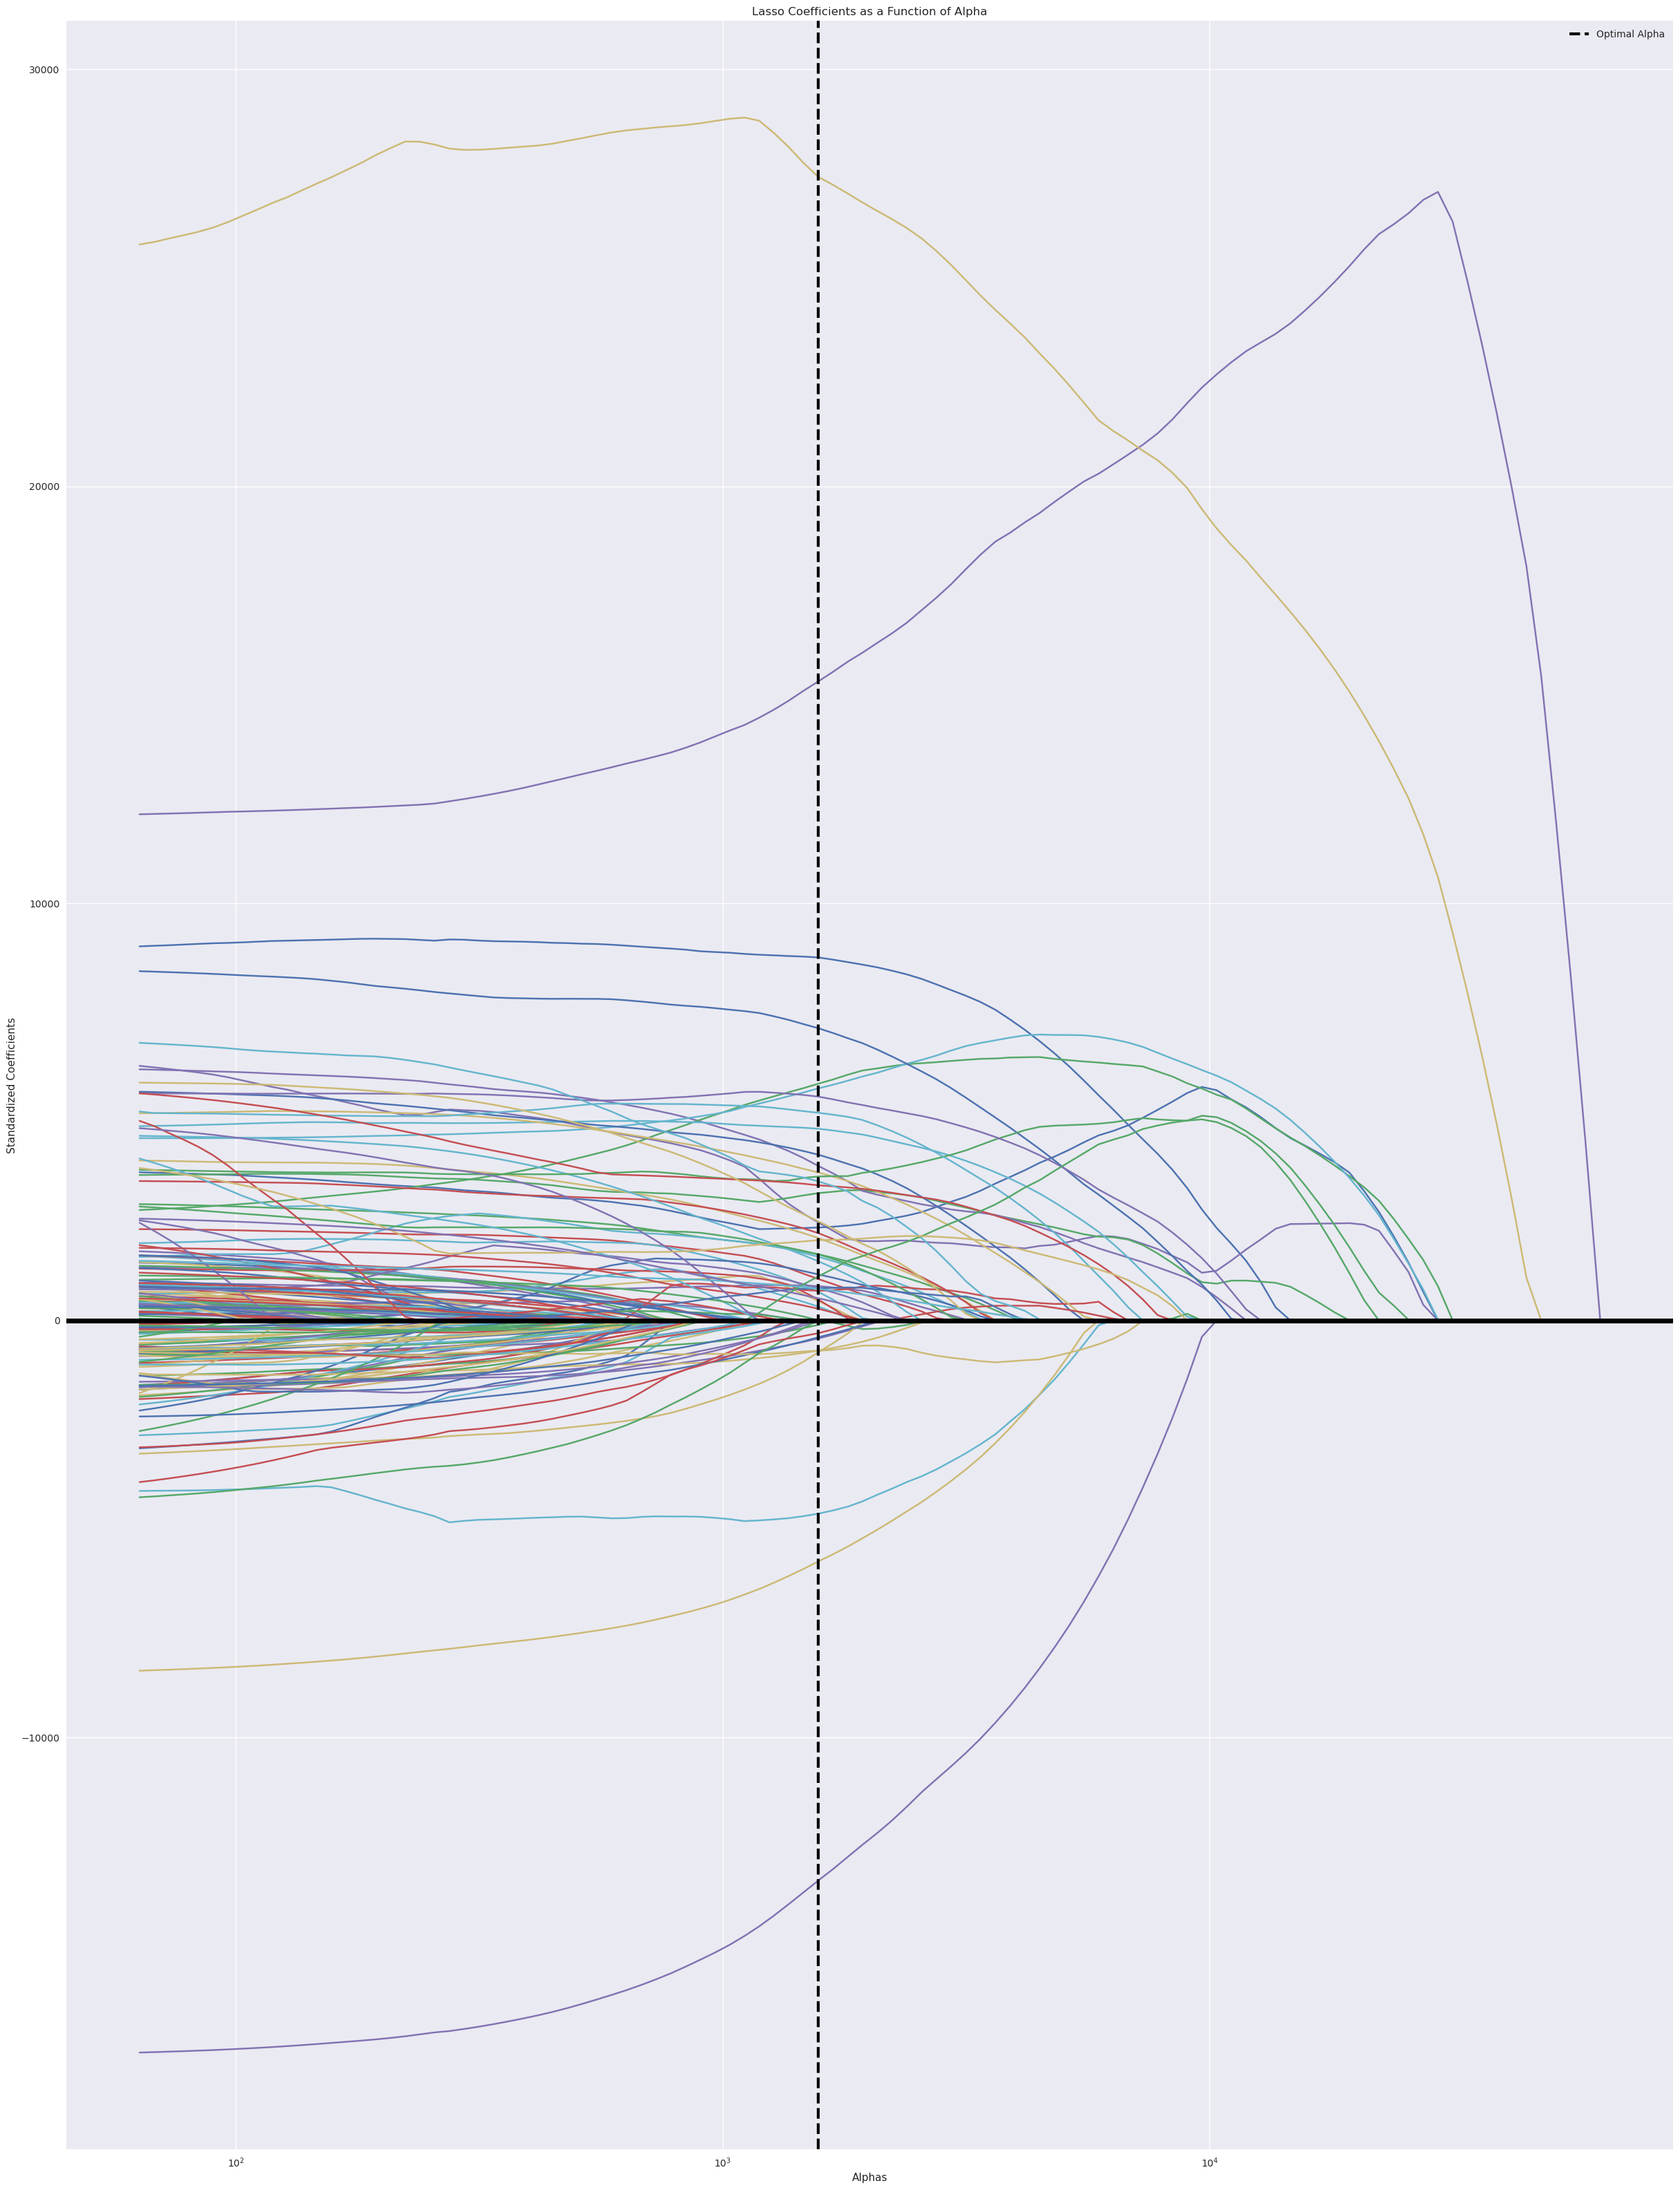

In [38]:
# for plotting the lasso we need to fit the data to Lasso instead of LassoCV and do it for each alpha
plt.rcParams["figure.figsize"] = (30,40)
plt.rcParams["font.size"] = 100
preprocessed_data = preprocess.fit_transform(raw_train)

# we copied the lasso-cv parameters to make it the same
lasso = Lasso(tol=0.001, random_state=42, max_iter=10000)
coefs = []

# applying the model for each alpha from the LassoCV results
for alpha_ in models_list['lasso-cv'].alphas_:
    lasso.set_params(alpha=alpha_)
    lasso.fit(preprocessed_data, target_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

# coefs is a list of lists, in a way that each list inside is a set 
# of coefficients (one of them is the best chosen by LassoCV)
ax.plot(models_list['lasso-cv'].alphas_, coefs)
# bolding the 0 line of y
plt.axhline(0, color='black', linewidth=5)
# bolding the best alpha calculated by LassoCV, 
# the intersected lines above 0 with the best alpha are the features selected
plt.axvline(models_list['lasso-cv'].alpha_, color='black', linewidth=3, linestyle="--", label="Optimal Alpha")
plt.legend()
ax.set_xscale('log')
plt.xlabel('Alphas')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha');

In [39]:
ax = plt.gca()

# mse_path_ is the "Mean square error for the test set on each fold, varying alpha." [from documentation]
ax.plot(models_list['lasso-cv'].alphas_, models_list['lasso-cv'].mse_path_)
# here we're plotting the mse mean in black bold line to view it properly
ax.plot(models_list['lasso-cv'].alphas_, models_list['lasso-cv'].mse_path_.mean(axis=-1),
        color='black', linewidth=5, label="Mean MSE")
plt.axvline(models_list['lasso-cv'].alpha_, color='black', linewidth=3, linestyle='--', label="Optimal Alpha")
plt.legend()
ax.set_xscale('log')
plt.xlabel('Alphas')
plt.ylabel('Mean Squared Error')
plt.title('Lasso MSE as a Function of Alpha');

<a id="10"></a>
<h2 style="text-align: center;">Save and Submit</h2>

In [40]:
preprocessed_train_full = preprocess.fit_transform(modified_train_data_without_target_and_id_dataframe)
preprocessed_test = preprocess.transform(raw_test_data_without_id_dataframe)

<h5 style="color: gray">this step is applying fit_transform on the full train dataset then training the lasso model in the list, lastly making a prediction on the test dataset, and that prediction will be submmitted (the best of all)
</h5>

In [41]:
lasso = models_list['lasso-cv'].fit(preprocessed_train_full, target_column)
predicted_test = lasso.predict(preprocessed_test)
result_dataframe = pd.DataFrame({"Id": raw_test_data_dataframe.Id, "SalePrice": predicted_test})
result_dataframe.head(10)

Id      SalePrice
0  1461  115914.087794
1  1462  172147.518842
2  1463  169629.464638
3  1464  182504.514881
4  1465  213148.897864
5  1466  163249.861411
6  1467  166630.163096
7  1468  152617.111643
8  1469  204108.358025
9  1470  112103.119973

In [42]:
result_dataframe.to_csv('submission.csv', index=False)

<a id="11"></a>
<h2 style="text-align: center;">Conclusion</h2>